In [114]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as consts
import ugradio
import scipy.optimize as opt

## Sun - Short Time

In [3]:
npz = np.load('SunRun1final.npz')

In [4]:
volts = npz['volts']
time = npz['time']

In [5]:
time = time - time[0]

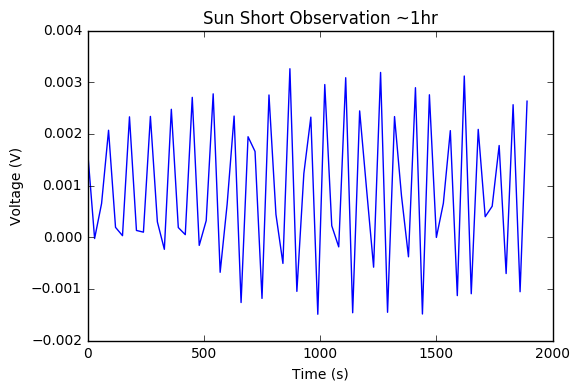

In [6]:
plt.plot(time, volts)
plt.title("Sun Short Observation ~1hr")
plt.xlabel("Time (s)")
plt.ylabel("Voltage (V)")
#plt.savefig('SunShortVolts.pdf', bbox_inches='tight')
plt.savefig('SunShortVolts.png')
plt.show()

In [7]:
ftvolts = np.fft.fft(volts)

In [8]:
sunft = np.abs(ftvolts)**2
sunfreqs = np.fft.fftfreq(len(ftvolts), 15)

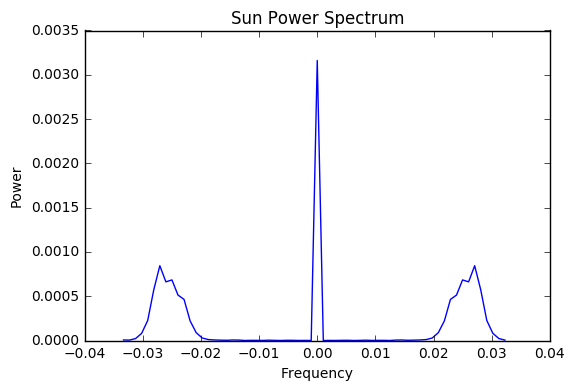

In [9]:
plt.plot(np.fft.fftshift(sunfreqs), np.fft.fftshift(sunft))
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.title("Sun Power Spectrum")
#plt.savefig('SunShortSpec.pdf', bbox_inches='tight')
plt.savefig('SunShortSpec.png')
plt.show()

In [10]:
ftvolts[np.where(np.abs(sunfreqs) < 0.01)] = 0

In [11]:
sunft = np.abs(ftvolts)**2
sunfreqs = np.fft.fftfreq(len(ftvolts), 15)

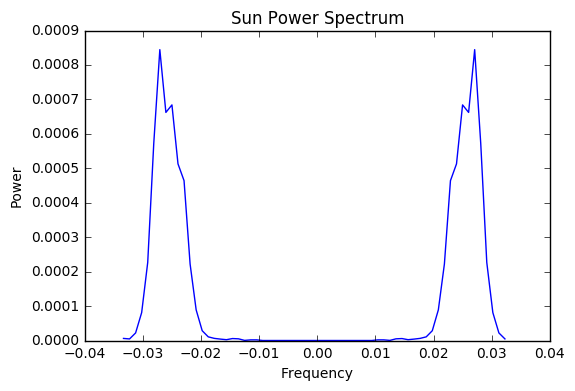

In [12]:
plt.plot(np.fft.fftshift(sunfreqs), np.fft.fftshift(sunft))
plt.ylabel("Power")
plt.xlabel("Frequency")
plt.title("Sun Power Spectrum")
#plt.savefig('SunShortSpec.pdf', bbox_inches='tight')
plt.savefig('SunShortSpec.png')
plt.show()

In [13]:
filtvolts = np.fft.ifft(ftvolts)

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


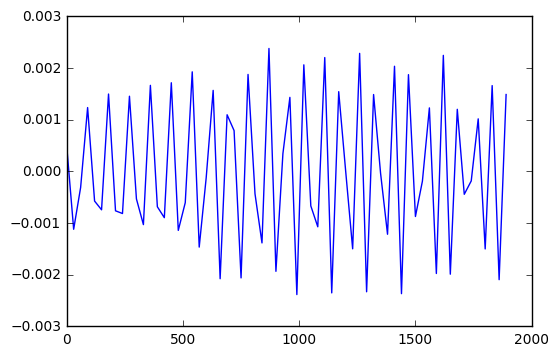

In [24]:
plt.plot(time, filtvolts)
plt.show()

Do these frequencies agree with the predicted values?

 H.A. = Local sidereal time - right ascension

In [14]:
unixtime = time
JDtime = ugradio.timing.julian_date(unixtime)
LSTtime = ugradio.timing.lst(jd = JDtime)

In [59]:
d = ugradio.coord.sunpos(JDtime[0])[1]
ra = ugradio.coord.sunpos(JDtime[0])[0]
l = consts.c/10.7e9
Bew = 20
Bns = 0
L = ugradio.coord.nch.lat
h = LSTtime - ra

In [60]:
Qew = (Bew*np.cos(d)/l)

In [61]:
Qns = (Bns*np.sin(L)*np.cos(d)/l)

In [62]:
ff = Qew*np.cos(h) - Qns*np.sin(h)

In [63]:
ffseconds = ff*2*np.pi/(60*60*24)

In [64]:
print(min(ffseconds), max(ffseconds))

(-0.017457576530666666, -0.014518051867733127)


In [65]:
d = ugradio.coord.sunpos(JDtime[-1])[1]
ra = ugradio.coord.sunpos(JDtime[-1])[0]
l = consts.c/10.7e9
Bew = 20
Bns = 0
L = ugradio.coord.nch.lat
h = LSTtime - ra

In [66]:
Qew = (Bew*np.cos(d)/l)

In [67]:
Qns = (Bns*np.sin(L)*np.cos(d)/l)

In [68]:
ff = Qew*np.cos(h) - Qns*np.sin(h)

In [69]:
ffseconds = ff*2*np.pi/(60*60*24)

In [70]:
print(min(ffseconds), max(ffseconds))

(-0.01799296150682958, -0.015099069409401467)


## Least Squares Fitting

In [21]:
Bns = 0
# solve for Qew
# Make a guess for Qew

In [84]:
def Fhs(h, A, B):
    Qns = 1 #Guess
    Qew = 200 #Guess
    l = consts.c/10.7e9
    d = ugradio.coord.sunpos(JDtime[0])[1]
    L = ugradio.coord.nch.lat
    Aterm = A*np.cos(2*np.pi*Qew*np.sin(h) + 2*np.pi*Qns*np.cos(h))
    Bterm = B*np.sin(2*np.pi*Qew*np.sin(h) + 2*np.pi*Qns*np.cos(h))
    return Aterm + Bterm

In [85]:
params, cov = opt.curve_fit(Fhs, h, volts)

In [86]:
A, B = params
Qew = 20
Qns = 0
print(A, B)

(-9.8404895287175262e-05, -3.5668315620449716e-05)


In [87]:
fhs = A*np.cos(2*np.pi*Qew*np.sin(h) + 2*np.pi*Qns*np.cos(h)) + B*np.sin(2*np.pi*Qew*np.sin(h) + 2*np.pi*Qns*np.cos(h))

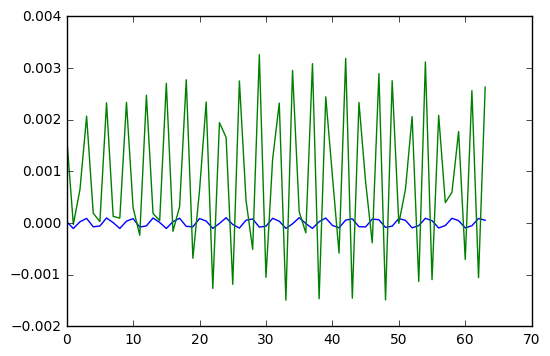

In [88]:
plt.plot(Fhs(h, A, B))
plt.plot(volts)
plt.show()

In [115]:
def GenerateFhs(Qew, Qns):
    
    def Fhs(h, A, B):
        l = consts.c/10.7e9
        d = ugradio.coord.sunpos(JDtime[0])[1]
        L = ugradio.coord.nch.lat
        Aterm = A*np.cos(2*np.pi*Qew*np.sin(h) + 2*np.pi*Qns*np.cos(h))
        Bterm = B*np.sin(2*np.pi*Qew*np.sin(h) + 2*np.pi*Qns*np.cos(h))
        return Aterm + Bterm

    return Fhs

In [168]:
def optimizeFhs():
    Qewvals = np.linspace(1, 30, 100)
    Qnsvals = np.linspace(0, 2, 20)
    residuals = []
    for ns in Qnsvals:
        for ew in Qewvals:
            Fhs = GenerateFhs(ew, ns)
            params, cov = opt.curve_fit(Fhs, h, volts)
            residual = volts - Fhs(h, params[0], params[1])
            residuals.append(np.sum(np.abs(residual)))
        print(100*ns/5)
    residuals = np.array(residuals)
    minresid = min(residuals)
    index = np.where(residuals == minresid)[0]
    residuals.reshape(len(Qnsvals), len(Qewvals))
    row = index//len(Qewvals)
    col = (index+4)%len(Qewvals)
    
    return minresid, Qnsvals[row][0], Qewvals[col][0]

In [170]:
optimized2 = optimizeFhs()

0.0
2.10526315789
4.21052631579
6.31578947368
8.42105263158
10.5263157895
12.6315789474
14.7368421053
16.8421052632
18.9473684211
21.0526315789
23.1578947368
25.2631578947
27.3684210526
29.4736842105
31.5789473684
33.6842105263
35.7894736842
37.8947368421
40.0


In [172]:
optimized2

(0.08364118277284005, 0.52631578947368418, 7.4444444444444446)

In [173]:
Qew = optimized2[2]
Bew = Qew*l/(np.cos(d))
Bew

-0.40445410932600506

In [167]:
optimized

(0.08364118277284005, 0.52631578947368418, 7.4444444444444446)

In [123]:
opti = optimizeFhs()

In [124]:
opti

(0.083649292089556543, array([ 6.97487437]))

## Crab Nebula

Don't see evidence of Crab Nebula signal in FT

In [11]:
npz = np.load('Crab_Longfinal.npz')

In [12]:
crabvolts = npz['volts']
crabtimes = npz['time']

<IPython.core.display.Javascript object>


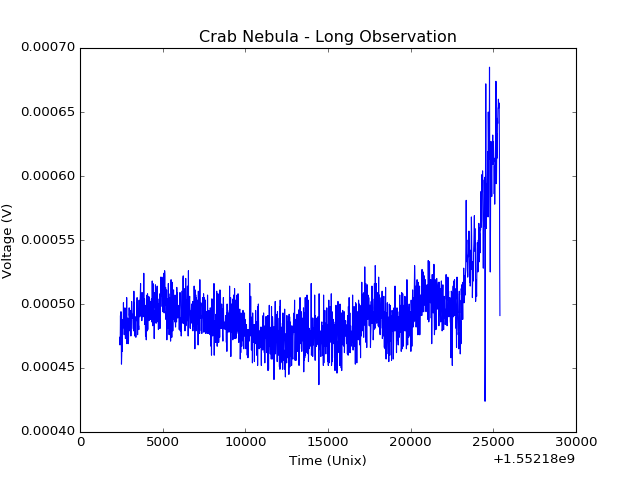

In [30]:
plt.plot(crabtimes, crabvolts)
plt.title("Crab Nebula - Long Observation")
plt.ylabel("Voltage (V)")
plt.xlabel("Time (Unix)")
#plt.savefig('CrabVolts.pdf', bbox_inches='tight')
plt.savefig('CrabVolts.png')
plt.show()

In [15]:
crabft = np.abs(np.fft.fft(crabvolts))**2
crabfreqs = np.fft.fftfreq(len(crabvolts), 15)

<IPython.core.display.Javascript object>


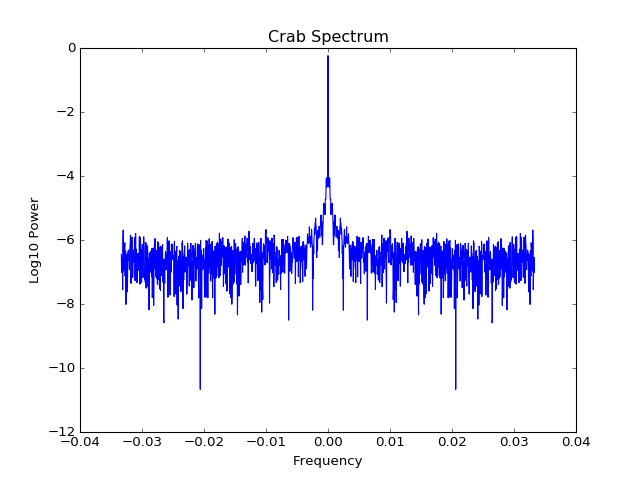

In [31]:
%matplotlib notebook
plt.plot(np.fft.fftshift(crabfreqs), np.log10(np.fft.fftshift(crabft)))
plt.title('Crab Spectrum')
plt.ylabel("Log10 Power")
plt.xlabel("Frequency")
#plt.savefig('CrabSpec.pdf', bbox_inches='tight')
plt.savefig('CrabSpec.png')
plt.show()

In [32]:
len(crabft)

1534

<IPython.core.display.Javascript object>


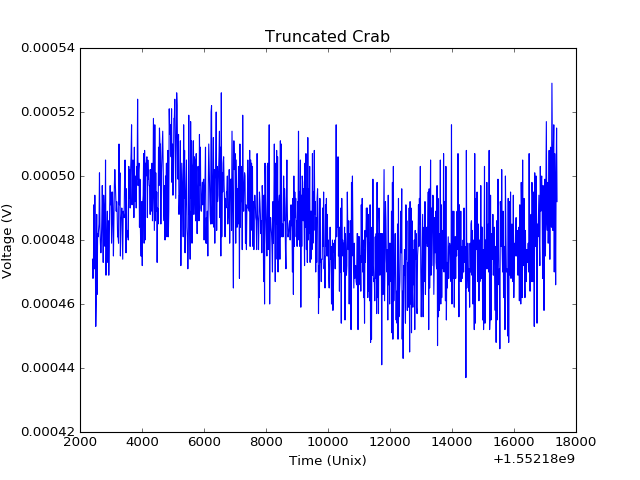

In [43]:
plt.plot(crabtimes[:1000], crabvolts[:1000])
plt.title('Truncated Crab')
plt.xlabel('Time (Unix)')
plt.ylabel('Voltage (V)')
plt.savefig('Trunkrab.png')
plt.show()

In [37]:
crabft1 = np.abs(np.fft.fft(crabvolts[0:1000]))**2
crabfreqs1 = np.fft.fftfreq(len(crabvolts[0:1000]), 15)

<IPython.core.display.Javascript object>


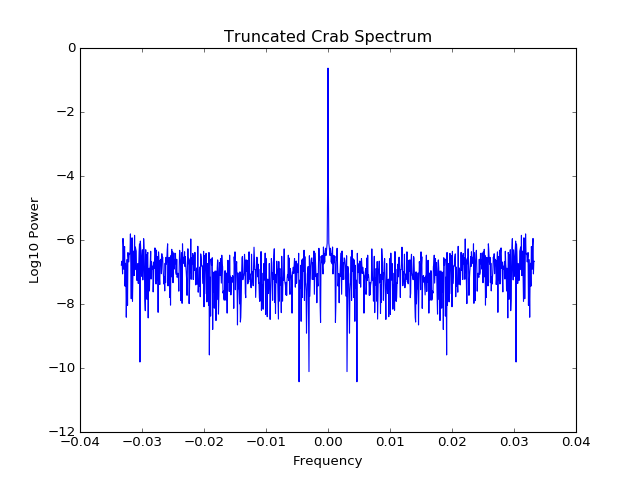

In [44]:
plt.plot(np.fft.fftshift(crabfreqs1), np.log10(np.fft.fftshift(crabft1)))
plt.title('Truncated Crab Spectrum')
plt.ylabel("Log10 Power")
plt.xlabel("Frequency")
#plt.savefig('CrabSpec.pdf', bbox_inches='tight')
plt.savefig('TrunkCrabSpec.png')
plt.show()